<a href="https://colab.research.google.com/github/IanEdington/learn/blob/master/machine-learning/ggl-mlcc/intro_to_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2018 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#Intro to Modeling


**Learning Objectives:**
* Become familiar with pandas for handling small datasets
* Use the tf.Estimator and Feature Column API to experiment with feature transformations
* Use visualizations and run experiments to understand the value of feature transformations

Please **make a copy** of this Colab notebook before starting this lab. To do so, choose **File**->**Save a copy in Drive**.

## Setup

Let's start by importing our dependencies.

In [2]:
%reset -f
import numpy as np
import pandas as pd
import math

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## Pandas, a helpful data analysis library for in-memory dataset

We use a package called [Pandas](http://pandas.pydata.org/) for reading in our data, exploring our data and doing some basic processing. It is really helpful for datasets that fit in memory! And it has some nice integrations, as you will see.

First we set up some options to control how items are displayed and the maximum number of rows to show when displaying a table.  Feel free to change this setup to whatever you'd like.

In [0]:
# Set pandas output display to have one digit for decimal places and limit it to
# printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

### Load the dataset with pandas
The car data set we will be using in this lab is provided as a comma separated file without a header row.  In order for each column to have a meaningful header name we must provide it.  We get the information about the columns from the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile).

We will use the features of the car, to try to predict its price.


In [4]:
# Provide the names for the columns since the CSV file with the data does
# not have a header row.
feature_names = ['symboling', 'normalized-losses', 'make', 'fuel-type',
        'aspiration', 'num-doors', 'body-style', 'drive-wheels',
        'engine-location', 'wheel-base', 'length', 'width', 'height', 'weight',
        'engine-type', 'num-cylinders', 'engine-size', 'fuel-system', 'bore',
        'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
        'highway-mpg', 'price']


# Load in the data from a CSV file that is comma separated.
car_data = pd.read_csv('https://storage.googleapis.com/mledu-datasets/cars_data.csv',
                        sep=',', names=feature_names, header=None, encoding='latin-1')


# We'll then randomize the data, just to be sure not to get any pathological
# ordering effects that might harm the performance of Stochastic Gradient
# Descent.
car_data = car_data.reindex(np.random.permutation(car_data.index))

print("Data set loaded. Num examples: ", len(car_data))

Data set loaded. Num examples:  205


This is a really small dataset! Only 205 examples.

For simplicity in this codelab, we do not split the data further into training and validation. But you MUST do this on real datasets, or else you will overfit to your single dataset.

## Task 0: Use pandas to explore and prepare the data

- Use Pandas to inspect the data and manually curate a list of numeric_feature_names and categorical_feature_names.


Useful functions:
- `type()` called on any Python object describes the type of the object
- `dataframe[4:7]` pulls out rows 4, 5, 6 in a Pandas dataframe
- `dataframe[['mycol1', 'mycol2']]` pulls out the two requested columns into a new Pandas dataframe
- `dataframe['mycol1']` returns a Pandas series -- not a dataframe!
- `dataframe.describe()` prints out statistics for each dataframe column

In [5]:
car_data[4:7]

,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,weight,engine-type,num-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
46,2,?,isuzu,gas,std,two,hatchback,rwd,front,96.00,172.60,65.20,51.40,2734,ohc,four,119,spfi,3.43,3.23,9.20,90,5000,24,29,11048
106,1,231,nissan,gas,std,two,hatchback,rwd,front,99.20,178.50,67.90,49.70,3139,ohcv,six,181,mpfi,3.43,3.27,9.00,160,5200,19,25,18399
181,-1,?,toyota,gas,std,four,wagon,rwd,front,104.50,187.80,66.50,54.10,3151,dohc,six,161,mpfi,3.27,3.35,9.20,156,5200,19,24,15750


c:  symboling  		 type:  <class 'numpy.int64'>
c:  normalized-losses  		 type:  <class 'str'>
c:  make  		 type:  <class 'str'>
c:  fuel-type  		 type:  <class 'str'>
c:  aspiration  		 type:  <class 'str'>
c:  num-doors  		 type:  <class 'str'>
c:  body-style  		 type:  <class 'str'>
c:  drive-wheels  		 type:  <class 'str'>
c:  engine-location  		 type:  <class 'str'>
c:  wheel-base  		 type:  <class 'numpy.float64'>
c:  length  		 type:  <class 'numpy.float64'>
c:  width  		 type:  <class 'numpy.float64'>
c:  height  		 type:  <class 'numpy.float64'>
c:  weight  		 type:  <class 'numpy.int64'>
c:  engine-type  		 type:  <class 'str'>
c:  num-cylinders  		 type:  <class 'str'>
c:  engine-size  		 type:  <class 'numpy.int64'>
c:  fuel-system  		 type:  <class 'str'>
c:  bore  		 type:  <class 'str'>
c:  stroke  		 type:  <class 'str'>
c:  compression-ratio  		 type:  <class 'numpy.float64'>
c:  horsepower  		 type:  <class 'str'>
c:  peak-rpm  		 type:  <class 'str'>
c:  city-mpg  		 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5c804980b8>,
      dtype=object)

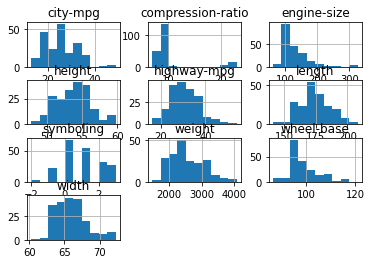

In [6]:
for c in car_data.columns:
  print("c: ", c, " \t\t type: ", type(car_data[c][1]))
car_data.hist()

In [0]:
numeric_feature_names = []
categorical_feature_names = []

In [0]:
def look_at_feature(feature):
  feature.hist()
  print(feature.head())
  print(feature.tail())
  return feature.describe()

In [9]:
for c in car_data.columns:
  print(f"look_at_feature(car_data[\"{c}\"])")

look_at_feature(car_data["symboling"])
look_at_feature(car_data["normalized-losses"])
look_at_feature(car_data["make"])
look_at_feature(car_data["fuel-type"])
look_at_feature(car_data["aspiration"])
look_at_feature(car_data["num-doors"])
look_at_feature(car_data["body-style"])
look_at_feature(car_data["drive-wheels"])
look_at_feature(car_data["engine-location"])
look_at_feature(car_data["wheel-base"])
look_at_feature(car_data["length"])
look_at_feature(car_data["width"])
look_at_feature(car_data["height"])
look_at_feature(car_data["weight"])
look_at_feature(car_data["engine-type"])
look_at_feature(car_data["num-cylinders"])
look_at_feature(car_data["engine-size"])
look_at_feature(car_data["fuel-system"])
look_at_feature(car_data["bore"])
look_at_feature(car_data["stroke"])
look_at_feature(car_data["compression-ratio"])
look_at_feature(car_data["horsepower"])
look_at_feature(car_data["peak-rpm"])
look_at_feature(car_data["city-mpg"])
look_at_feature(car_data["highway-mpg"])
look_at_feat

90     1
17     0
103    0
174   -1
46     2
Name: symboling, dtype: int64
39     0
198   -2
109    0
150    1
95     1
Name: symboling, dtype: int64


count   205.00
mean      0.83
std       1.25
min      -2.00
25%       0.00
50%       1.00
75%       2.00
max       3.00
Name: symboling, dtype: float64

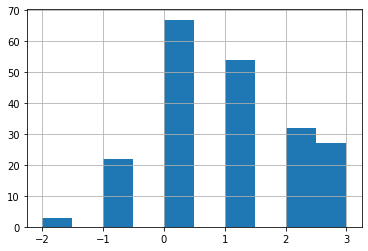

In [10]:
numeric_feature_names.append("symboling")
look_at_feature(car_data["symboling"])

90     128
17       ?
103    108
174     65
46       ?
Name: normalized-losses, dtype: object
39      85
198    103
109      ?
150     87
95     128
Name: normalized-losses, dtype: object


count     205
unique     52
top         ?
freq       41
Name: normalized-losses, dtype: object

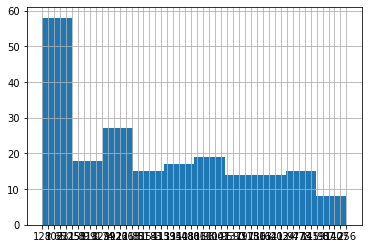

In [11]:
numeric_feature_names.append("normalized-losses")
look_at_feature(car_data["normalized-losses"])

90     nissan
17        bmw
103    nissan
174    toyota
46      isuzu
Name: make, dtype: object
39      honda
198     volvo
109    peugot
150    toyota
95     nissan
Name: make, dtype: object


count        205
unique        22
top       toyota
freq          32
Name: make, dtype: object

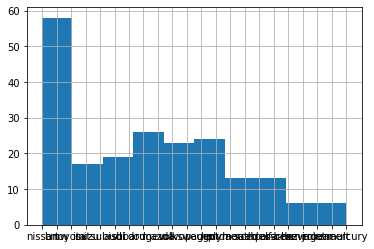

In [12]:
categorical_feature_names.append("make")
look_at_feature(car_data["make"])


90     diesel
17        gas
103       gas
174    diesel
46        gas
Name: fuel-type, dtype: object
39     gas
198    gas
109    gas
150    gas
95     gas
Name: fuel-type, dtype: object


count     205
unique      2
top       gas
freq      185
Name: fuel-type, dtype: object

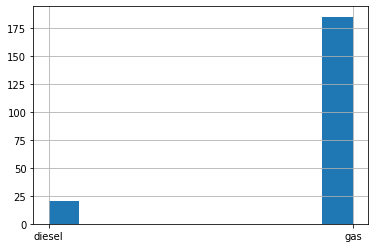

In [13]:
categorical_feature_names.append("fuel-type")

look_at_feature(car_data["fuel-type"])


90       std
17       std
103      std
174    turbo
46       std
Name: aspiration, dtype: object
39       std
198    turbo
109      std
150      std
95       std
Name: aspiration, dtype: object


count     205
unique      2
top       std
freq      168
Name: aspiration, dtype: object

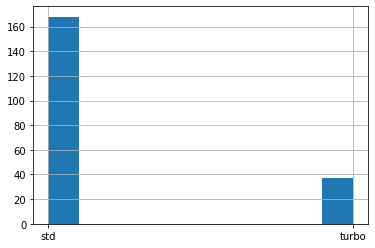

In [14]:
categorical_feature_names.append("aspiration")

look_at_feature(car_data["aspiration"])


90      two
17     four
103    four
174    four
46      two
Name: num-doors, dtype: object
39     four
198    four
109    four
150     two
95      two
Name: num-doors, dtype: object


count      205
unique       3
top       four
freq       114
Name: num-doors, dtype: object

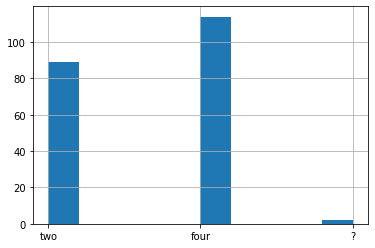

In [15]:
categorical_feature_names.append("num-doors")

look_at_feature(car_data["num-doors"])


90         sedan
17         sedan
103        sedan
174        sedan
46     hatchback
Name: body-style, dtype: object
39         sedan
198        sedan
109        wagon
150    hatchback
95     hatchback
Name: body-style, dtype: object


count       205
unique        5
top       sedan
freq         96
Name: body-style, dtype: object

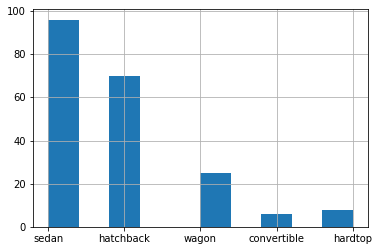

In [16]:
categorical_feature_names.append("body-style")
look_at_feature(car_data["body-style"])


90     fwd
17     rwd
103    fwd
174    fwd
46     rwd
Name: drive-wheels, dtype: object
39     fwd
198    rwd
109    rwd
150    fwd
95     fwd
Name: drive-wheels, dtype: object


count     205
unique      3
top       fwd
freq      120
Name: drive-wheels, dtype: object

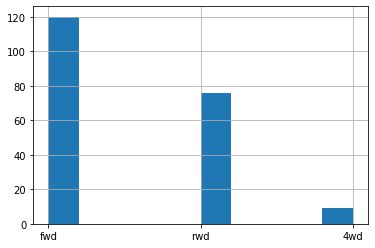

In [17]:
categorical_feature_names.append("drive-wheels")

look_at_feature(car_data["drive-wheels"])


90     front
17     front
103    front
174    front
46     front
Name: engine-location, dtype: object
39     front
198    front
109    front
150    front
95     front
Name: engine-location, dtype: object


count       205
unique        2
top       front
freq        202
Name: engine-location, dtype: object

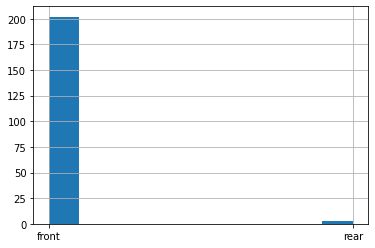

In [18]:
categorical_feature_names.append("engine-locations")

look_at_feature(car_data["engine-location"])


90     94.50
17    110.00
103   100.40
174   102.40
46     96.00
Name: wheel-base, dtype: float64
39     96.50
198   104.30
109   114.20
150    95.70
95     94.50
Name: wheel-base, dtype: float64


count   205.00
mean     98.76
std       6.02
min      86.60
25%      94.50
50%      97.00
75%     102.40
max     120.90
Name: wheel-base, dtype: float64

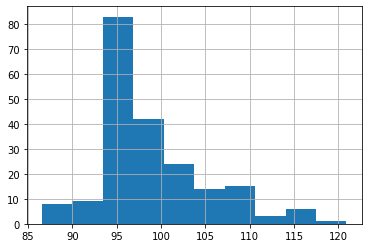

In [19]:

numeric_feature_names.append("wheel-bases")
look_at_feature(car_data["wheel-base"])


90    165.30
17    197.00
103   184.60
174   175.60
46    172.60
Name: length, dtype: float64
39    175.40
198   188.80
109   198.90
150   158.70
95    165.60
Name: length, dtype: float64


count   205.00
mean    174.05
std      12.34
min     141.10
25%     166.30
50%     173.20
75%     183.10
max     208.10
Name: length, dtype: float64

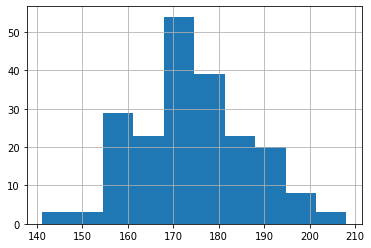

In [20]:

numeric_feature_names.append("length")
look_at_feature(car_data["length"])


90    63.80
17    70.90
103   66.50
174   66.50
46    65.20
Name: width, dtype: float64
39    65.20
198   67.20
109   68.40
150   63.60
95    63.80
Name: width, dtype: float64


count   205.00
mean     65.91
std       2.15
min      60.30
25%      64.10
50%      65.50
75%      66.90
max      72.30
Name: width, dtype: float64

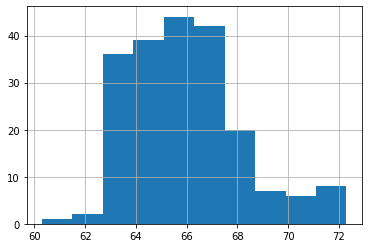

In [21]:

numeric_feature_names.append("width")
look_at_feature(car_data["width"])


90    54.50
17    56.30
103   55.10
174   54.90
46    51.40
Name: height, dtype: float64
39    54.10
198   56.20
109   58.70
150   54.50
95    53.30
Name: height, dtype: float64


count   205.00
mean     53.72
std       2.44
min      47.80
25%      52.00
50%      54.10
75%      55.50
max      59.80
Name: height, dtype: float64

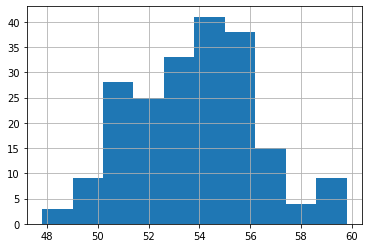

In [22]:

numeric_feature_names.append("height")
look_at_feature(car_data["height"])


90     2017
17     3505
103    3060
174    2480
46     2734
Name: weight, dtype: int64
39     2304
198    3045
109    3230
150    1985
95     2028
Name: weight, dtype: int64


count    205.00
mean    2555.57
std      520.68
min     1488.00
25%     2145.00
50%     2414.00
75%     2935.00
max     4066.00
Name: weight, dtype: float64

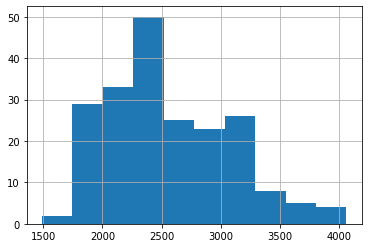

In [23]:

numeric_feature_names.append("weight")
look_at_feature(car_data["weight"])


90      ohc
17      ohc
103    ohcv
174     ohc
46      ohc
Name: engine-type, dtype: object
39     ohc
198    ohc
109      l
150    ohc
95     ohc
Name: engine-type, dtype: object


count     205
unique      7
top       ohc
freq      148
Name: engine-type, dtype: object

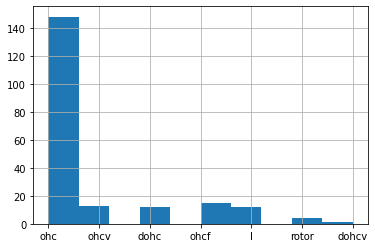

In [24]:

categorical_feature_names.append("engine-type")
look_at_feature(car_data["engine-type"])


90     four
17      six
103     six
174    four
46     four
Name: num-cylinders, dtype: object
39     four
198    four
109    four
150    four
95     four
Name: num-cylinders, dtype: object


count      205
unique       7
top       four
freq       159
Name: num-cylinders, dtype: object

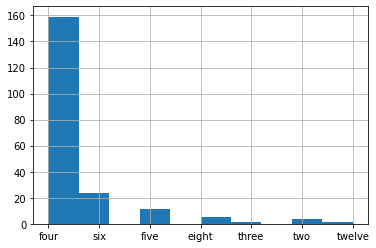

In [25]:

categorical_feature_names.append("num-cylinders")
look_at_feature(car_data["num-cylinders"])


90     103
17     209
103    181
174    110
46     119
Name: engine-size, dtype: int64
39     110
198    130
109    120
150     92
95      97
Name: engine-size, dtype: int64


count   205.00
mean    126.91
std      41.64
min      61.00
25%      97.00
50%     120.00
75%     141.00
max     326.00
Name: engine-size, dtype: float64

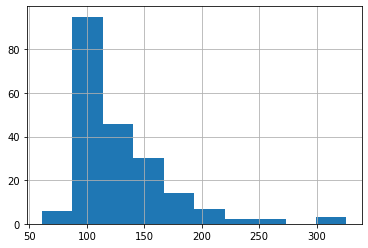

In [26]:

numeric_feature_names.append("engine-size")
look_at_feature(car_data["engine-size"])


90      idi
17     mpfi
103    mpfi
174     idi
46     spfi
Name: fuel-system, dtype: object
39     1bbl
198    mpfi
109    mpfi
150    2bbl
95     2bbl
Name: fuel-system, dtype: object


count      205
unique       8
top       mpfi
freq        94
Name: fuel-system, dtype: object

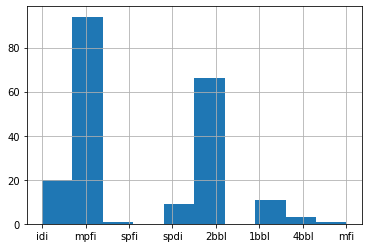

In [27]:

categorical_feature_names.append("fuel-system")
look_at_feature(car_data["fuel-system"])


90     2.99
17     3.62
103    3.43
174    3.27
46     3.43
Name: bore, dtype: object
39     3.15
198    3.62
109    3.46
150    3.05
95     3.15
Name: bore, dtype: object


count      205
unique      39
top       3.62
freq        23
Name: bore, dtype: object

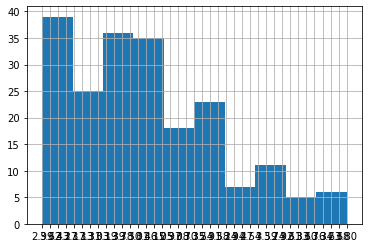

In [28]:

numeric_feature_names.append("bore")
look_at_feature(car_data["bore"])


90     3.47
17     3.39
103    3.27
174    3.35
46     3.23
Name: stroke, dtype: object
39     3.58
198    3.15
109    3.19
150    3.03
95     3.29
Name: stroke, dtype: object


count      205
unique      37
top       3.40
freq        20
Name: stroke, dtype: object

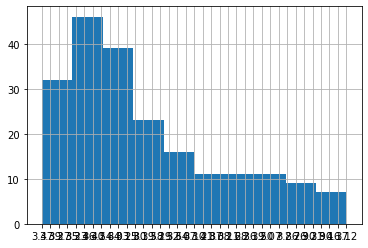

In [29]:

numeric_feature_names.append("stroke")
look_at_feature(car_data["stroke"])


90    21.90
17     8.00
103    9.00
174   22.50
46     9.20
Name: compression-ratio, dtype: float64
39    9.00
198   7.50
109   8.40
150   9.00
95    9.40
Name: compression-ratio, dtype: float64


count   205.00
mean     10.14
std       3.97
min       7.00
25%       8.60
50%       9.00
75%       9.40
max      23.00
Name: compression-ratio, dtype: float64

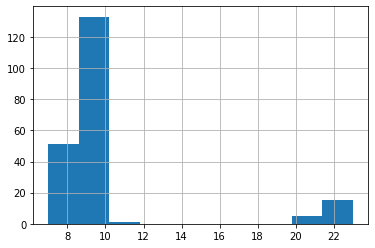

In [30]:

numeric_feature_names.append("compression-ratio")
look_at_feature(car_data["compression-ratio"])


90      55
17     182
103    152
174     73
46      90
Name: horsepower, dtype: object
39      86
198    162
109     97
150     62
95      69
Name: horsepower, dtype: object


count     205
unique     60
top        68
freq       19
Name: horsepower, dtype: object

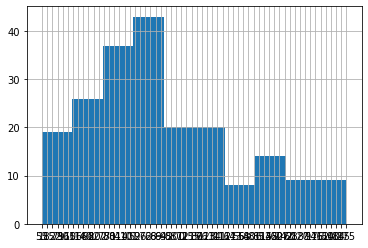

In [31]:

numeric_feature_names.append("horsepower")
look_at_feature(car_data["horsepower"])


90     4800
17     5400
103    5200
174    4500
46     5000
Name: peak-rpm, dtype: object
39     5800
198    5100
109    5000
150    4800
95     5200
Name: peak-rpm, dtype: object


count      205
unique      24
top       5500
freq        37
Name: peak-rpm, dtype: object

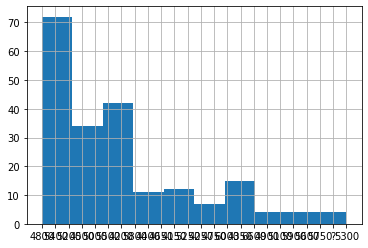

In [32]:

numeric_feature_names.append("peak-rpm")
look_at_feature(car_data["peak-rpm"])


90     45
17     15
103    19
174    30
46     24
Name: city-mpg, dtype: int64
39     27
198    17
109    19
150    35
95     31
Name: city-mpg, dtype: int64


count   205.00
mean     25.22
std       6.54
min      13.00
25%      19.00
50%      24.00
75%      30.00
max      49.00
Name: city-mpg, dtype: float64

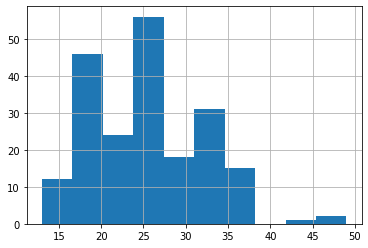

In [33]:

numeric_feature_names.append("city-mpg")
look_at_feature(car_data["city-mpg"])

90     50
17     20
103    25
174    33
46     29
Name: highway-mpg, dtype: int64
39     33
198    22
109    24
150    39
95     37
Name: highway-mpg, dtype: int64


count   205.00
mean     30.75
std       6.89
min      16.00
25%      25.00
50%      30.00
75%      34.00
max      54.00
Name: highway-mpg, dtype: float64

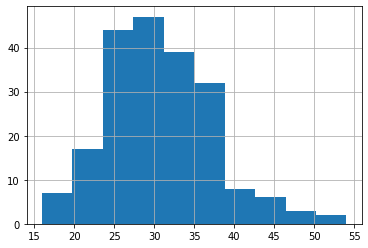

In [34]:
numeric_feature_names.append("highway-mpg")
look_at_feature(car_data["highway-mpg"])


In [35]:
print(numeric_feature_names)
print(len(numeric_feature_names))
print(categorical_feature_names)
print(len(categorical_feature_names))
# The correct solution will pass these assert statements.
assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

['symboling', 'normalized-losses', 'wheel-bases', 'length', 'width', 'height', 'weight', 'engine-size', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']
15
['make', 'fuel-type', 'aspiration', 'num-doors', 'body-style', 'drive-wheels', 'engine-locations', 'engine-type', 'num-cylinders', 'fuel-system']
10


In [0]:
#@title Solution (to view code, from cell's menu, select Form -> Show Code)
LABEL = "price"
numeric_feature_names = ['symboling', 'normalized-losses', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-size', 'horsepower',
        'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke',
         'compression-ratio']

categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))

assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

In [37]:
# Run to inspect numeric features.
car_data[numeric_feature_names]

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,horsepower,peak-rpm,city-mpg,highway-mpg,bore,stroke,compression-ratio
90,1,128,94.50,165.30,63.80,54.50,2017,103,55,4800,45,50,2.99,3.47,21.90
17,0,?,110.00,197.00,70.90,56.30,3505,209,182,5400,15,20,3.62,3.39,8.00
103,0,108,100.40,184.60,66.50,55.10,3060,181,152,5200,19,25,3.43,3.27,9.00
174,-1,65,102.40,175.60,66.50,54.90,2480,110,73,4500,30,33,3.27,3.35,22.50
46,2,?,96.00,172.60,65.20,51.40,2734,119,90,5000,24,29,3.43,3.23,9.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,0,85,96.50,175.40,65.20,54.10,2304,110,86,5800,27,33,3.15,3.58,9.00
198,-2,103,104.30,188.80,67.20,56.20,3045,130,162,5100,17,22,3.62,3.15,7.50
109,0,?,114.20,198.90,68.40,58.70,3230,120,97,5000,19,24,3.46,3.19,8.40
150,1,87,95.70,158.70,63.60,54.50,1985,92,62,4800,35,39,3.05,3.03,9.00


In [38]:
# Run to inspect categorical features.
car_data[categorical_feature_names]

,num-doors,make,fuel-system,fuel-type,num-cylinders,engine-type,engine-location,aspiration,drive-wheels,body-style
90,two,nissan,idi,diesel,four,ohc,front,std,fwd,sedan
17,four,bmw,mpfi,gas,six,ohc,front,std,rwd,sedan
103,four,nissan,mpfi,gas,six,ohcv,front,std,fwd,sedan
174,four,toyota,idi,diesel,four,ohc,front,turbo,fwd,sedan
46,two,isuzu,spfi,gas,four,ohc,front,std,rwd,hatchback
...,...,...,...,...,...,...,...,...,...,...
39,four,honda,1bbl,gas,four,ohc,front,std,fwd,sedan
198,four,volvo,mpfi,gas,four,ohc,front,turbo,rwd,sedan
109,four,peugot,mpfi,gas,four,l,front,std,rwd,wagon
150,two,toyota,2bbl,gas,four,ohc,front,std,fwd,hatchback


In [0]:
# Coerce the numeric features to numbers. This is necessary because the model
# crashes because not all the values are numeric.
for feature_name in numeric_feature_names + [LABEL]:
  car_data[feature_name] = pd.to_numeric(car_data[feature_name], errors='coerce')

# Fill missing values with 0.
# Is this an OK thing to do? You may want to come back and revisit this decision later.
car_data.fillna(0, inplace=True)

## Task 1: Make your best model with numeric features. No normalization allowed.

Modify the model provided below to achieve the lowest eval loss. You may want to change various hyperparameters:
- learning rate
- choice of optimizer
- hidden layer dimensions -- make sure your choice here makes sense given the number of training examples
- batch size
- num training steps
- (anything else you can think of changing)

Do not use the `normalizer_fn` arg on `numeric_column`.

In [40]:
# This code "works", but because of bad hyperparameter choices it gets NaN loss
# during training. Try fixing this.

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name) for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']

model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=

In [41]:
#@title Possible solution
# Here is one possible solution:
# The only necessary change to fix the NaN training loss was the choice of optimizer.

# Changing other parameters could improve model quality, but take it with a
# grain of salt. The dataset is very small.

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name) for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the 
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']
model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=t

### Visualize your model's predictions

After you have a trained model, it may be helpful to understand how your model's inference differs from the actual data.

This helper function `scatter_plot_inference` does that for you. Real data is in grey. Your model's predictions are in orange.


In [0]:
from matplotlib import pyplot as plt


def scatter_plot_inference_grid(est, x_df, feature_names):
  """Plots the predictions of the model against each feature.
  
  Args:
    est: The trained tf.Estimator.
    x_df: The pandas dataframe with the input data (used to create
      predict_input_fn).
    feature_names: An iterable of string feature names to plot.
  """
  def scatter_plot_inference(axis,
                             x_axis_feature_name,
                             y_axis_feature_name,
                             predictions):
    """Generate one subplot."""
    # Plot the real data in grey.
    y_axis_feature_name = 'price'
    axis.set_ylabel(y_axis_feature_name)
    axis.set_xlabel(x_axis_feature_name)
    axis.scatter(car_data[x_axis_feature_name],
                 car_data[y_axis_feature_name],
                 c='grey')

    # Plot the predicted data in orange.
    axis.scatter(car_data[x_axis_feature_name], predictions, c='orange')

  predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

  predictions = [
    x['predictions'][0]
    for x in est.predict(predict_input_fn)
  ]
  
  num_cols = 2
  num_rows = int(math.ceil(len(feature_names)/float(num_cols)))
  f, axarr = plt.subplots(num_rows, num_cols)
  size = 6
  f.set_size_inches(num_cols*size, num_rows*size)
  
  for i, feature_name in enumerate(numeric_feature_names):
    axis = axarr[int(i/num_cols), i%num_cols]
    scatter_plot_inference(axis, feature_name, 'price', predictions)
  plt.show()


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpwxqapdo4/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


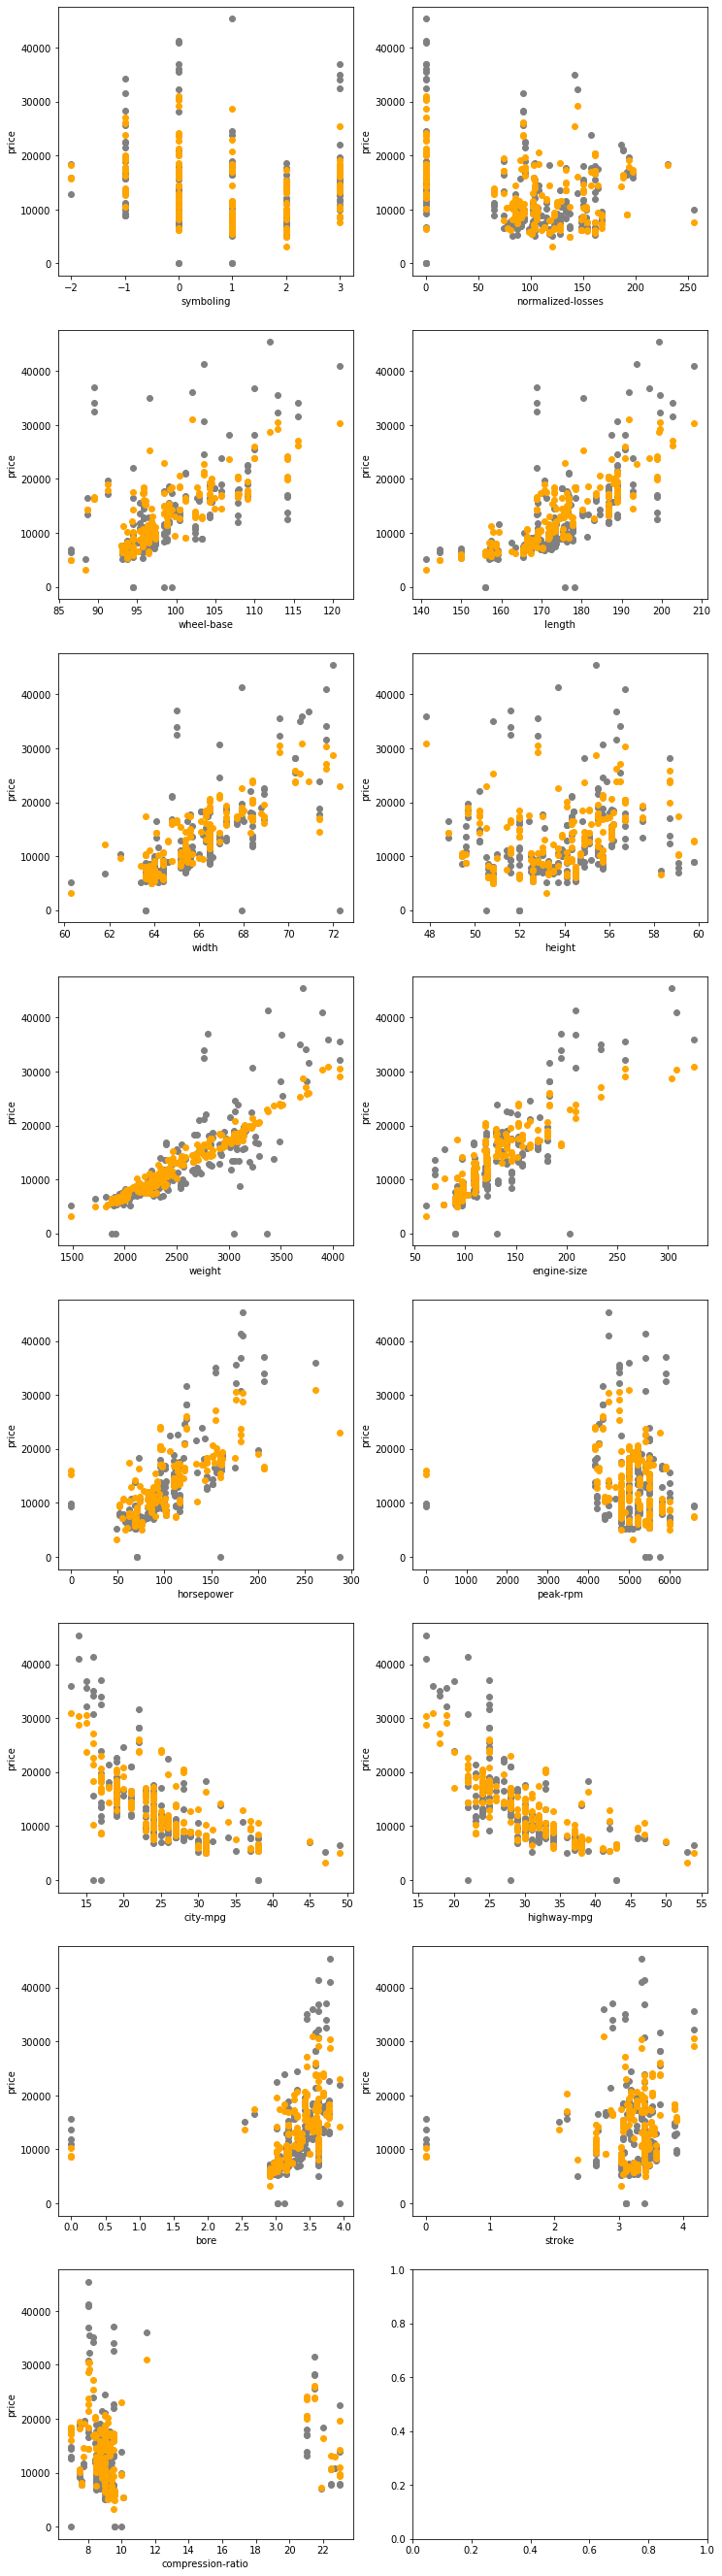

In [43]:
scatter_plot_inference_grid(est, x_df, numeric_feature_names)

## Task 2: Take your best numeric model from earlier. Add normalization.

### Add normalization to your best numeric model from earlier

- You decide what type of normalization to add, and for which features
- You will need to use the `normalizer_fn` arg on [`numeric_column`](https://g3doc.corp.google.com/learning/brain/public/g3doc/api_docs/python/tf/feature_column/numeric_column.md?cl=head)
    - An example of a silly normalizer_fn that shifts inputs down by 1, and then negates the value:
    
         normalizer_fn = lambda x: tf.neg(tf.subtract(x, 1))

- You may find these pandas functions helpful:
    - dataframe.mean()['your_feature_name']
    - dataframe.std()['your_feature_name']
- You will need to retune the hyperparameters from earlier.


**Does normalization improve model quality on this dataset? Why or why not?**

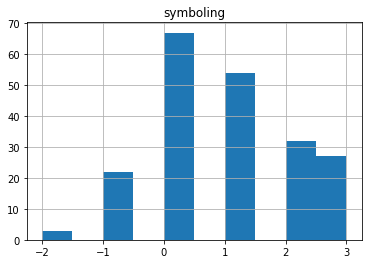

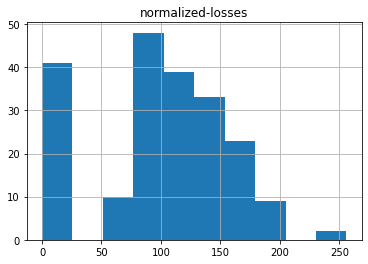

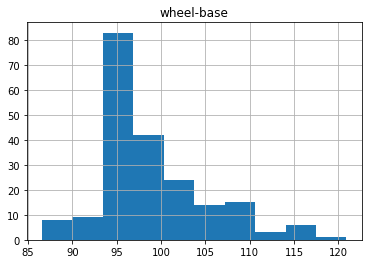

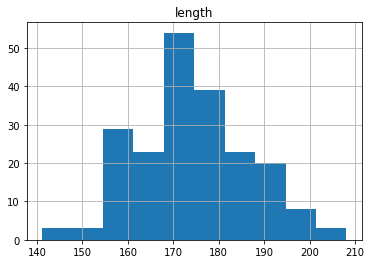

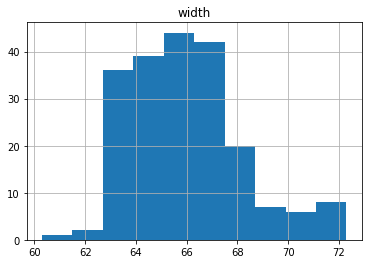

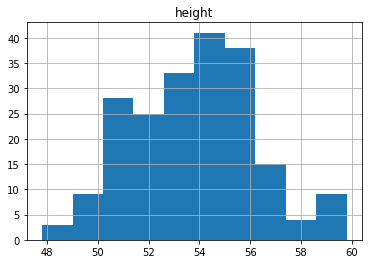

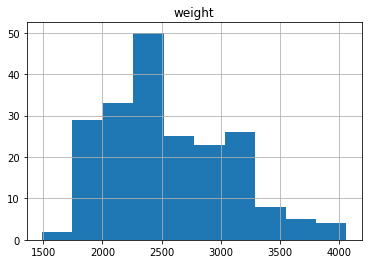

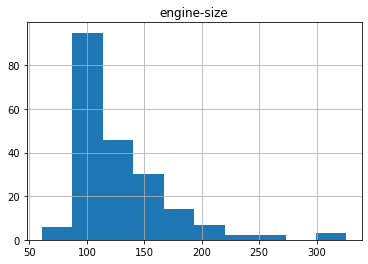

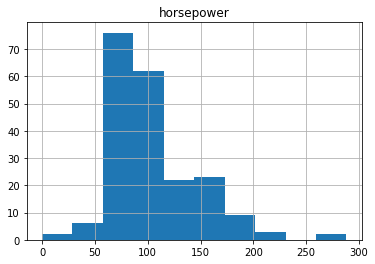

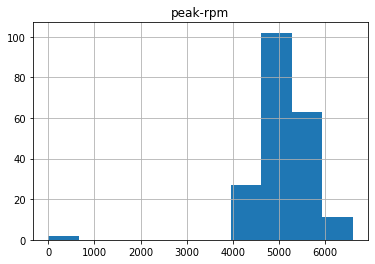

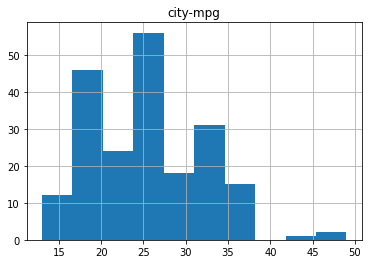

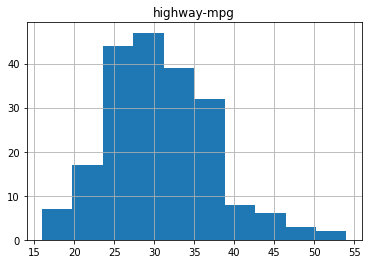

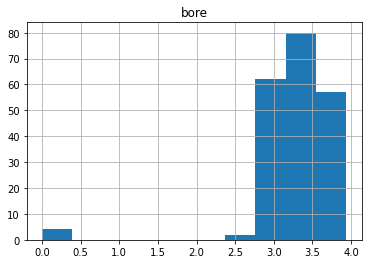

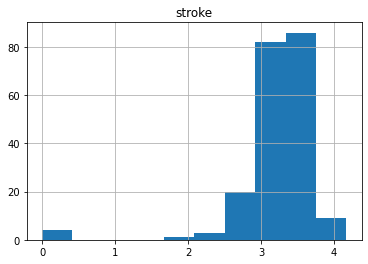

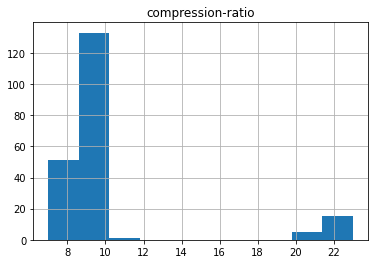

In [44]:
# This 1D visualization of each numeric feature might inform your normalization
# decisions.
for feature_name in numeric_feature_names:
  car_data.hist(column=feature_name)

###Train your model with numeric features + normalization

In [0]:
def make_score_plot(all_scores):
  # get data in right format
  # could add a sort by x_label but we'll trust the data for now
  x_label = "global_step"
  x = [scores["global_step"] for scores in all_scores]
  y_labels = [key for key in all_scores[0]]
  y_labels.remove("global_step")
  y_s = {
      label: [scores[label] for scores in all_scores]
      for label in y_labels
  }

  y_s["average_loss"] = [x/(10**6) for x in y_s["average_loss"]]
  plt.plot(x, y_s["average_loss"], label = "average_loss" + " (/10^6)")

  y_s["loss"] = [x/(10**7) for x in y_s["loss"]]
  plt.plot(x, y_s["loss"], label = "loss" + " (/10^7)")

  for label, stats in y_s.items():
    print(label)
    print(stats)
  
  # plt.xlabel('x - axis')
  # plt.ylabel('y - axis')
  plt.title('scores')
  plt.legend()

Start by normalizing all feature using their Z-scores

think about
- bucketting (symboling?)
- using mean for nulls
- non linear relationships (plot price vs feature)

model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f5c7ce80950>), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f5c7cef6730>), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f5c7f909c80>), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f5c7f909a60>), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f5c7f909400>), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.f

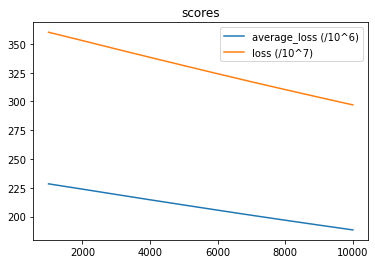

In [46]:
batch_size = 16
means = car_data.mean()[numeric_feature_names]
stds = car_data.std()[numeric_feature_names]

x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
def generate_numberic_feature_normalizer(feature_name):
  return lambda x: (x - means[feature_name]) / stds[feature_name]

model_feature_columns = [
    tf.feature_column.numeric_column(
        feature_name,
        normalizer_fn=generate_numberic_feature_normalizer(feature_name)
        )
    for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
all_scores = []
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  all_scores.append(scores)
  print('scores:', scores)

make_score_plot(all_scores)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphrgu7fnx/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


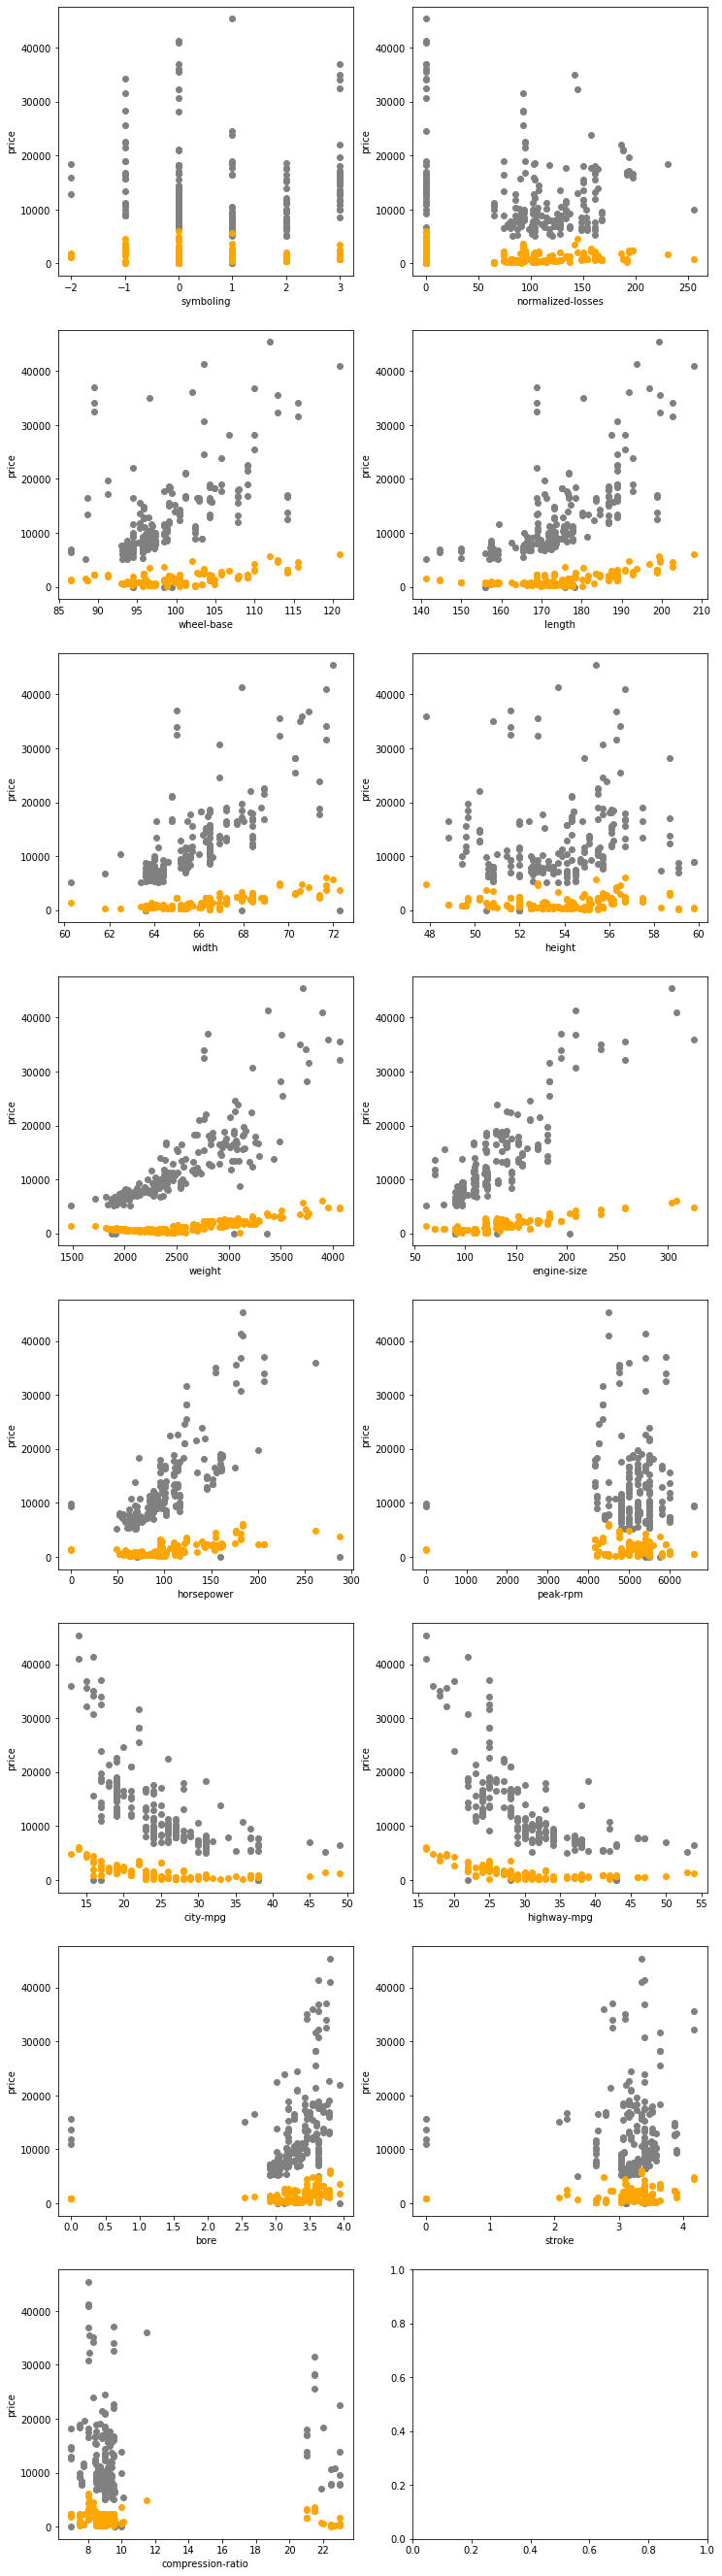

In [47]:
scatter_plot_inference_grid(est, x_df, numeric_feature_names)

In [48]:
transformed = (car_data['length'] - means['length'] ) / stds['length']
print(transformed.describe())
transformed

count   205.00
mean     -0.00
std       1.00
min      -2.67
25%      -0.63
50%      -0.07
75%       0.73
max       2.76
Name: length, dtype: float64


90    -0.71
17     1.86
103    0.86
174    0.13
46    -0.12
       ... 
39     0.11
198    1.20
109    2.01
150   -1.24
95    -0.68
Name: length, Length: 205, dtype: float64

In [49]:
# There's an issue with this model
# I didn't add an epsilon to avoid divide by zero
# how can I see in the data that this has happend?

# div_by_0 = car_data['length'] / 0
# print(div_by_0)

# divide by zero causes `inf` in pandas. This would cause a LOT of squew!

# why didn't I see this when using describe?

# print(div_by_0.describe())

transform_all_numberic_features = (x_df - means) / stds
print(transform_all_numberic_features)
transform_all_numberic_features.describe()

# based on the describe feature it doesn't seem like there are any inf cause by
# not including epsilon = 0.000001
# I would expect adding epsilon not to make a difference to the model

     symboling  normalized-losses  wheel-base  ...  bore  stroke  compression-ratio
90        0.13               0.52       -0.71  ... -0.51    0.51               2.96
17       -0.67              -1.67        1.87  ...  0.66    0.36              -0.54
103      -0.67               0.18        0.27  ...  0.31    0.14              -0.29
174      -1.47              -0.56        0.61  ...  0.01    0.29               3.11
46        0.94              -1.67       -0.46  ...  0.31    0.07              -0.24
..         ...                ...         ...  ...   ...     ...                ...
39       -0.67              -0.22       -0.37  ... -0.21    0.71              -0.29
198      -2.28               0.09        0.92  ...  0.66   -0.08              -0.67
109      -0.67              -1.67        2.56  ...  0.36   -0.00              -0.44
150       0.13              -0.18       -0.51  ... -0.40   -0.29              -0.29
95        0.13               0.52       -0.71  ... -0.21    0.18            

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,horsepower,peak-rpm,city-mpg,highway-mpg,bore,stroke,compression-ratio
count,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00
mean,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.28,-1.67,-2.02,-2.67,-2.61,-2.42,-2.05,-1.58,-2.53,-7.31,-1.87,-2.14,-6.10,-5.81,-0.79
25%,-0.67,-0.35,-0.71,-0.63,-0.84,-0.71,-0.79,-0.72,-0.81,-0.40,-0.95,-0.84,-0.25,-0.17,-0.39
50%,0.13,0.09,-0.29,-0.07,-0.19,0.15,-0.27,-0.17,-0.20,0.18,-0.19,-0.11,0.08,0.18,-0.29
75%,0.94,0.68,0.61,0.73,0.46,0.73,0.73,0.34,0.31,0.61,0.73,0.47,0.59,0.40,-0.19
max,1.74,2.72,3.68,2.76,2.98,2.49,2.90,4.78,4.52,2.19,3.63,3.38,1.26,1.78,3.24


model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f5c75ff7620>), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f5c75ff7510>), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f5c75ff7bf8>), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f5c770386a8>), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f5c77038840>), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.f

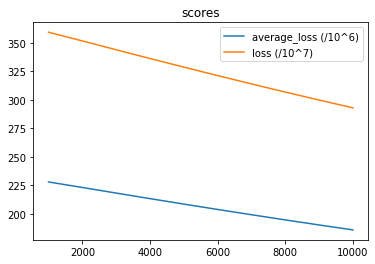

In [80]:
batch_size = 16

x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
means = x_df.mean()
stds = x_df.std()
def generate_numberic_feature_normalizer(feature_name):
  return lambda x: (x - means[feature_name]) / (epsilon + stds[feature_name])

model_feature_columns = [
    tf.feature_column.numeric_column(
        feature_name,
        normalizer_fn=generate_numberic_feature_normalizer(feature_name)
        # normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name])
        )
    for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
all_scores = []
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  all_scores.append(scores)
  print('scores:', scores)

make_score_plot(all_scores)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp99baq0fz/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


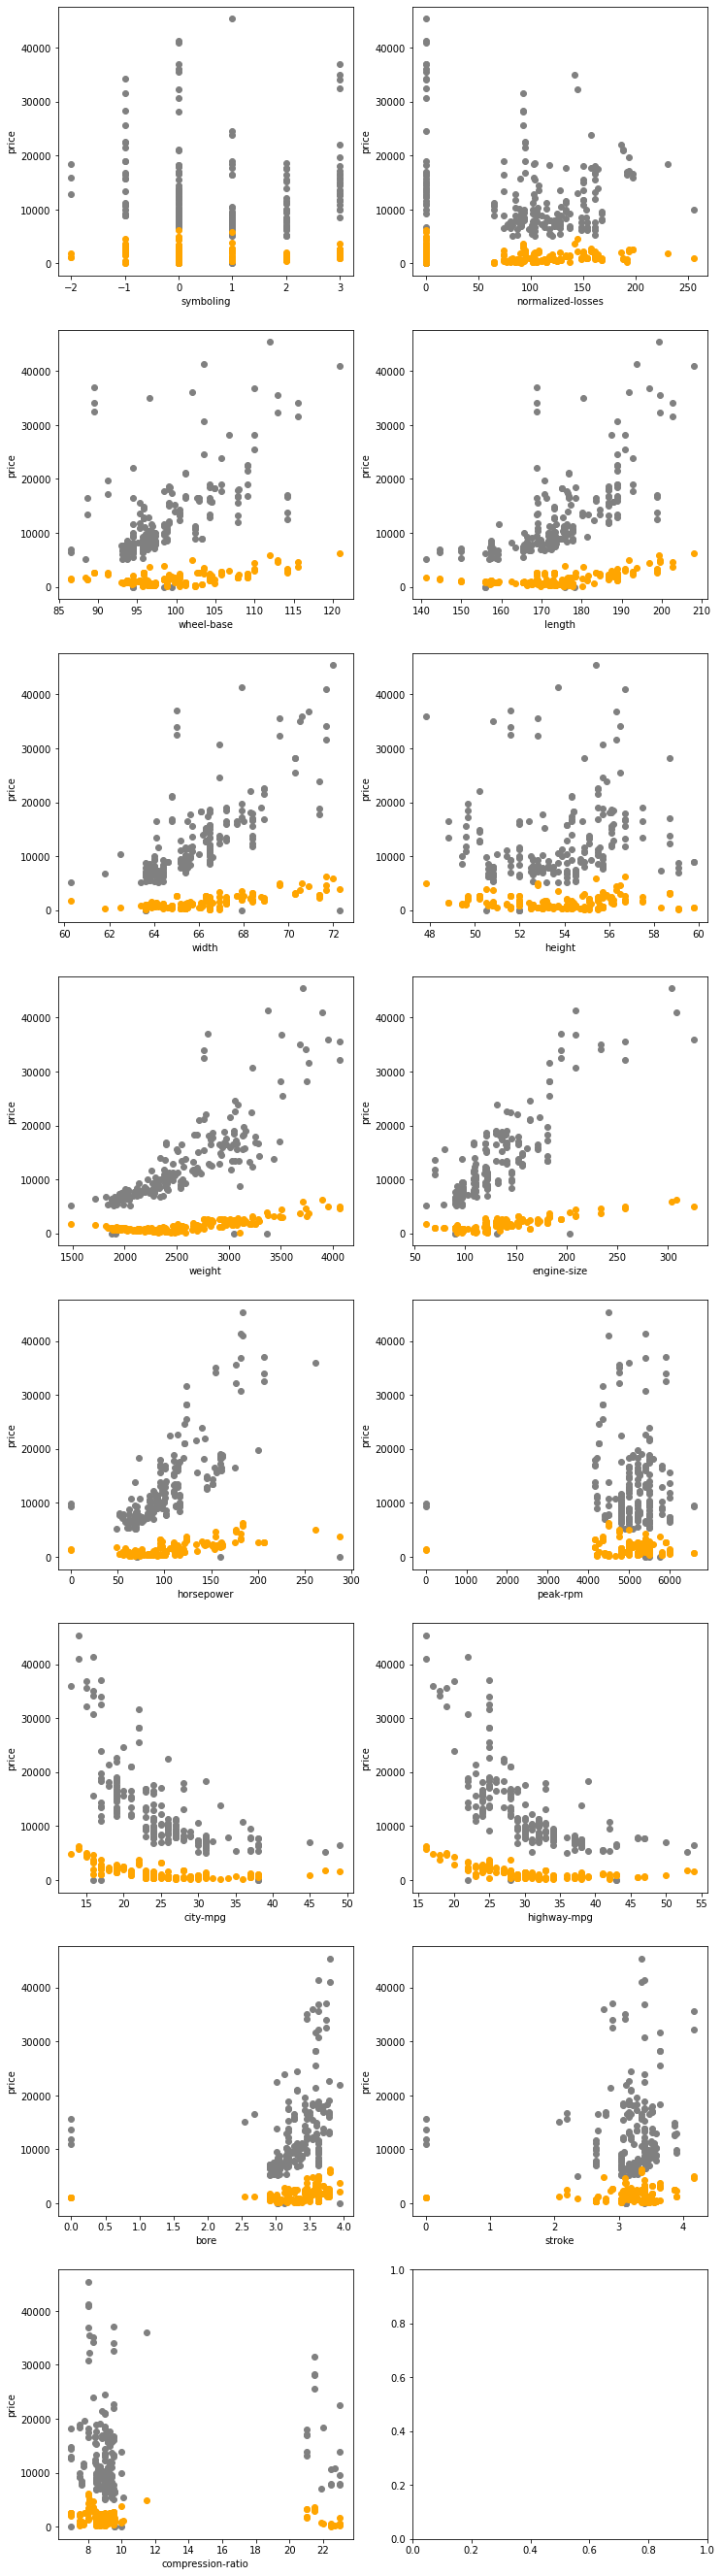

In [51]:
scatter_plot_inference_grid(est, x_df, numeric_feature_names)

In [52]:
# epsilon is good to remember but it doesn't look like it was the issue

# How would I know if there was an inf in my data set?


means_length = (x_df['length'] - means['length']) / stds['length']
means_length[0] /= 0
means_length.describe()
# if there was an `inf` it would show up in the describe
# takehomes
# 1. use the describe when making transformations, easy way to catch a mistake
# 2. div by zero is DANGEROUS!!! Common Ian, why don't you remember that!

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


count   205.00
mean      -inf
std        nan
min       -inf
25%      -0.63
50%      -0.07
75%       0.73
max       2.76
Name: length, dtype: float64

In [78]:
# TODO What is the next thing my error could be caused by?
# the only difference seems to be the lambda.
# I switched the def for the lambda and it's working

# I'm worried that the lambda and the def have different scoping rules
# (I don't know python very well)

def generate_numberic_feature_normalizer(feature_name):
  return lambda x: {"mean": x_df.mean()[feature_name], "std": epsilon + x_df.std()[feature_name]}

def_normalizers = dict()
lambda_normalizers = dict()
for feature_name in numeric_feature_names:
  def_normalizers[feature_name] = generate_numberic_feature_normalizer(feature_name)
  lambda_normalizers[feature_name] = lambda val: {"mean": x_df.mean()[feature_name], "std": epsilon + x_df.std()[feature_name]}

for key in def_normalizers:
  print(key, ':')
  print('  def :', def_normalizers[key](1))
  print('  lambda :', lambda_normalizers[key](1))
  print('  should be :', {"mean": car_data.mean()[key], "std": car_data.std()[key]})

# it seems that the scoping isn't the issue but instead the for loop.
# The last value of the for loop is used as the value of feature_name each time the lambda is called

symboling :
  def : {'mean': 0.8341463414634146, 'std': 1.2453078281055305}
  lambda : {'mean': 10.142536585365855, 'std': 3.9720413218632933}
  should be : {'mean': 0.8341463414634146, 'std': 1.2453068281055306}
normalized-losses :
  def : {'mean': 97.6, 'std': 58.282073715372796}
  lambda : {'mean': 10.142536585365855, 'std': 3.9720413218632933}
  should be : {'mean': 97.6, 'std': 58.2820727153728}
wheel-base :
  def : {'mean': 98.75658536585367, 'std': 6.021776685025571}
  lambda : {'mean': 10.142536585365855, 'std': 3.9720413218632933}
  should be : {'mean': 98.75658536585367, 'std': 6.021775685025571}
length :
  def : {'mean': 174.04926829268297, 'std': 12.337289526555177}
  lambda : {'mean': 10.142536585365855, 'std': 3.9720413218632933}
  should be : {'mean': 174.04926829268297, 'std': 12.337288526555177}
width :
  def : {'mean': 65.90780487804878, 'std': 2.145204852687183}
  lambda : {'mean': 10.142536585365855, 'std': 3.9720413218632933}
  should be : {'mean': 65.9078048780487

In [0]:
# the question still remains, why does this perform so poorly?
# especially over a model that is doing a random transform ('mean': 10.14, 'std': 3.97) for everything

# I'll try normalizing feature one at a time instead of all at once

model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='horsepower', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='peak-rpm', shape=(1,), default_value=None

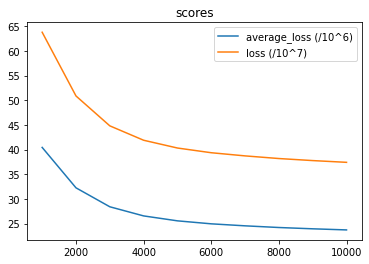

In [86]:
batch_size = 16

x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
means = x_df.mean()
stds = x_df.std()
def generate_numberic_feature_normalizer(feature_name):
  return lambda x: (x - means[feature_name]) / (epsilon + stds[feature_name])

model_feature_columns = []
numeric_feature_to_normalize = []
for feature_name in numeric_feature_names:
  normalizer_fn = None
  if feature_name in numeric_feature_to_normalize:
    normalizer_fn=generate_numberic_feature_normalizer(feature_name)

  model_feature_columns.append(
     tf.feature_column.numeric_column(
          feature_name,
          normalizer_fn=normalizer_fn
        ))

print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
all_scores = []
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  all_scores.append(scores)
  print('scores:', scores)

make_score_plot(all_scores)

model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='horsepower', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='peak-rpm', shape=(1,), default_value=None

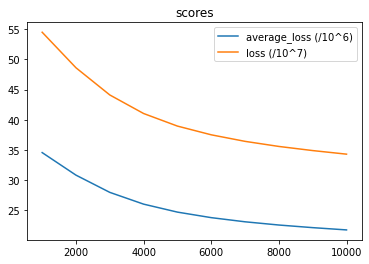

In [88]:
batch_size = 16

x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
means = x_df.mean()
stds = x_df.std()
def generate_numberic_feature_normalizer(feature_name):
  return lambda x: (x - means[feature_name]) / (epsilon + stds[feature_name])

model_feature_columns = []
numeric_feature_to_normalize = ["peak-rpm"]
for feature_name in numeric_feature_names:
  normalizer_fn = None
  if feature_name in numeric_feature_to_normalize:
    normalizer_fn=generate_numberic_feature_normalizer(feature_name)

  model_feature_columns.append(
     tf.feature_column.numeric_column(
          feature_name,
          normalizer_fn=normalizer_fn
        ))

print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.02),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
all_scores = []
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  all_scores.append(scores)
  print('scores:', scores)

make_score_plot(all_scores)

I noticed that the graph wasn't shaped like the first one and thought about learning rate. I wondered if learning rate would need to increase as normalization was put in place.

I'm going to try one more normalizing one more feature this way then go back to normalizing all of them and adjusting the learning rate

model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f5c7cfb6598>), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='horsepower', shape=(1,), default_value=None, dtype=tf.float32, no

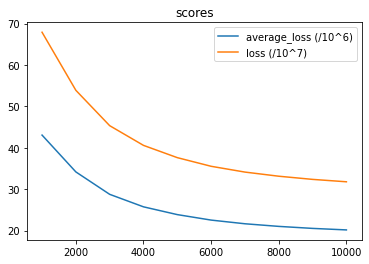

In [89]:
batch_size = 16

x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
means = x_df.mean()
stds = x_df.std()
def generate_numberic_feature_normalizer(feature_name):
  return lambda x: (x - means[feature_name]) / (epsilon + stds[feature_name])

model_feature_columns = []
numeric_feature_to_normalize = ["peak-rpm", "weight"]
for feature_name in numeric_feature_names:
  normalizer_fn = None
  if feature_name in numeric_feature_to_normalize:
    normalizer_fn=generate_numberic_feature_normalizer(feature_name)

  model_feature_columns.append(
     tf.feature_column.numeric_column(
          feature_name,
          normalizer_fn=normalizer_fn
        ))

print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.02),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
all_scores = []
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  all_scores.append(scores)
  print('scores:', scores)

make_score_plot(all_scores)

model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f5c7f246ae8>), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f5c7f2469d8>), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f5c7f246a60>), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f5c7cdbe268>), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f5c7cdbeae8>), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.f

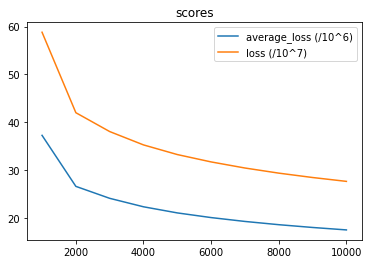

In [91]:
batch_size = 16

x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
means = x_df.mean()
stds = x_df.std()
def generate_numberic_feature_normalizer(feature_name):
  return lambda x: (x - means[feature_name]) / (epsilon + stds[feature_name])

model_feature_columns = [
    tf.feature_column.numeric_column(
        feature_name,
        normalizer_fn=generate_numberic_feature_normalizer(feature_name)
        )
    for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.1),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
all_scores = []
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  all_scores.append(scores)
  print('scores:', scores)

make_score_plot(all_scores)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp5oy_a9tp/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


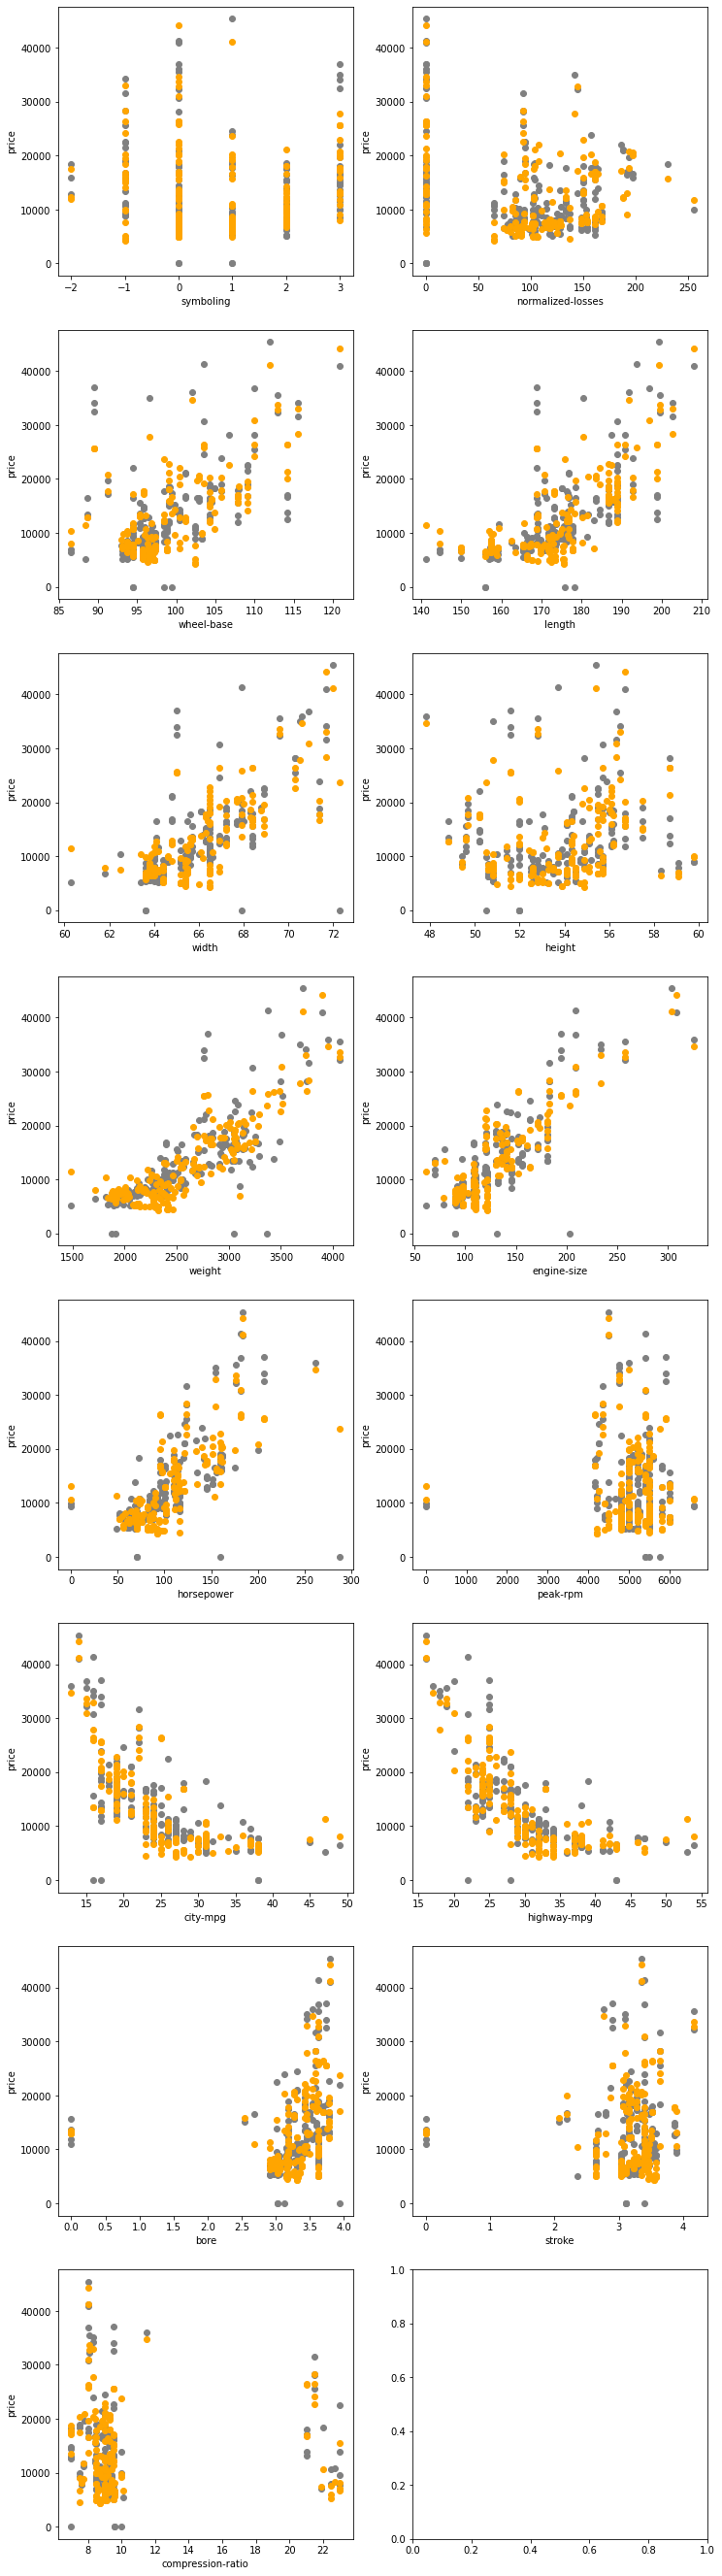

In [92]:
scatter_plot_inference_grid(est, x_df, numeric_feature_names)

normalizing everything and bumping up the learning rate really improved the model performance

['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']
model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f5c75f53840>), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f5c75f537b8>), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f5c75f53510>), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f5c76c87048>), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f5c76c87268>), NumericColumn(key='height', shape=(1,), default_va

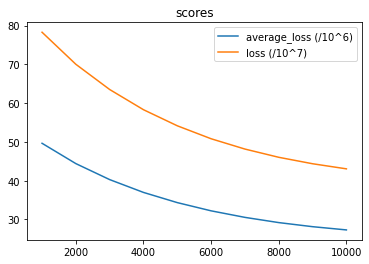

In [59]:
# This does Z-score normalization since the distributions for most features looked
# roughly normally distributed.

# Z-score normalization subtracts the mean and divides by the standard deviation,
# to give a roughly standard normal distribution (mean = 0, std = 1) under a
# normal distribution assumption. Epsilon prevents divide by zero.

# With normalization, are you able to get the model working with
# GradientDescentOptimizer? Z-score normalization doesn't seem to be able to get
# SGD working. Maybe a different type of normalization would?

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Epsilon prevents divide by zero.
epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
all_scores = []
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the 
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)
  all_scores.append(scores)

make_score_plot(all_scores)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp6p83sr3q/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


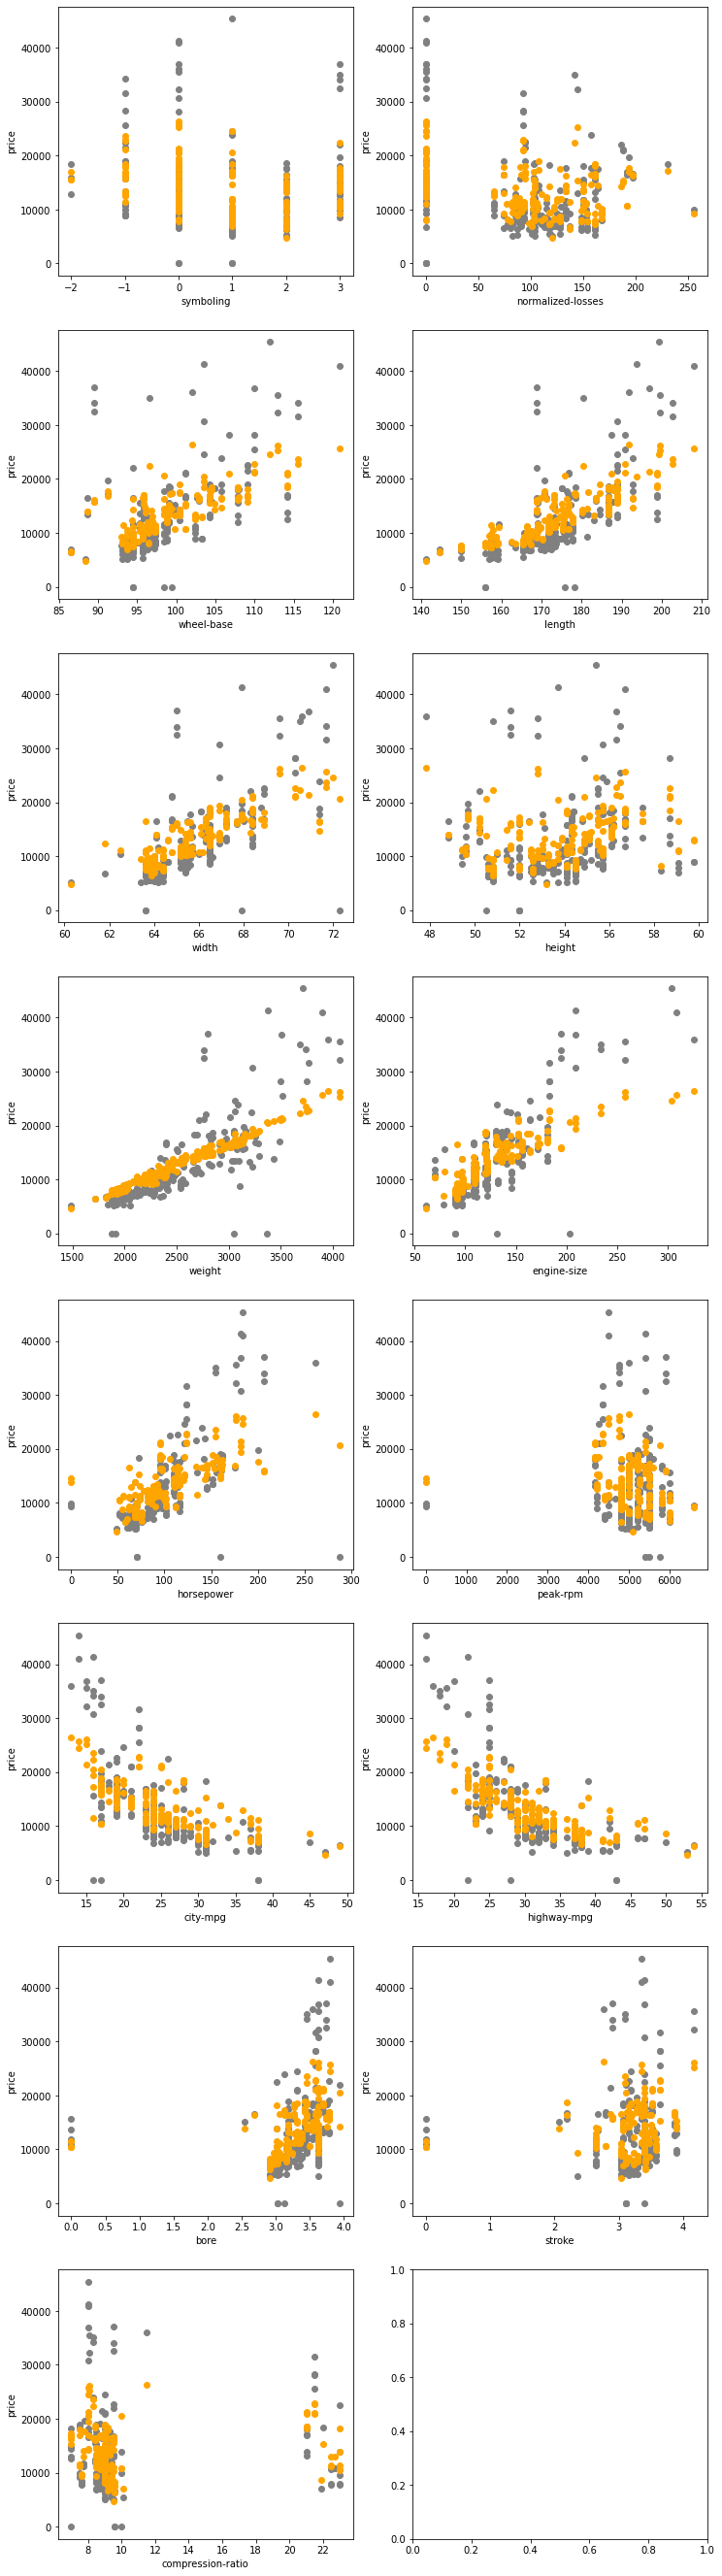

In [60]:
scatter_plot_inference_grid(est, x_df, numeric_feature_names)

In [94]:
# attempting to implement the GradientDescentOptimizer

batch_size = 16

x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
means = x_df.mean()
stds = x_df.std()
def generate_numberic_feature_normalizer(feature_name):
  return lambda x: (x - means[feature_name]) / (epsilon + stds[feature_name])

model_feature_columns = [
    tf.feature_column.numeric_column(
        feature_name,
        normalizer_fn=generate_numberic_feature_normalizer(feature_name)
        )
    for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
all_scores = []
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  all_scores.append(scores)
  print('scores:', scores)

make_score_plot(all_scores)

model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f5c7f854400>), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f5c76a076a8>), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f5c76a078c8>), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f5c76a07950>), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f5c76a079d8>), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.f

NanLossDuringTrainingError: ignored

## Task 3: Make your best model using only categorical features

- Look at the possible feature columns for categorical features. They begin with `categorical_column_with_` in go/tf-ops.
- You may find `dataframe[categorical_feature_names].unique()` helpful.


In [0]:
## Your code goes here

In [56]:
#@title Possible solution
# We have the full list of values that each feature takes on, and the list is
# relatively small so we use categorical_column_with_vocabulary_list.

batch_size = 16

x_df = car_data[categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



model_feature_columns [IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='num-doors', vocabulary_list=('two', 'four', '?'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='make', vocabulary_list=('nissan', 'bmw', 'toyota', 'isuzu', 'mitsubishi', 'audi', 'subaru', 'dodge', 'mazda', 'volvo', 'volkswagen', 'peugot', 'honda', 'plymouth', 'saab', 'mercedes-benz', 'porsche', 'alfa-romero', 'chevrolet', 'jaguar', 'renault', 'mercury'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fuel-system', vocabulary_list=('idi', 'mpfi', 'spfi', 'spdi', '2bbl', '1bbl', '4bbl', 'mfi'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fuel-type', vocabulary_list=('diesel', 'gas'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColu

## Task 4: Using all the features, make the best model that you can make

With all the features combined, your model should perform better than your earlier models using numerical and categorical models alone. Tune your model until that is the case.

In [0]:
## Your code goes here

In [58]:
#@title Possible solution
# This is a first pass at a model that uses all the features.
# Do you have any improvements?

batch_size = 16

x_df = car_data[numeric_feature_names + categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
] + [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]


print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the 
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



model_feature_columns [IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='num-doors', vocabulary_list=('two', 'four', '?'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='make', vocabulary_list=('nissan', 'bmw', 'toyota', 'isuzu', 'mitsubishi', 'audi', 'subaru', 'dodge', 'mazda', 'volvo', 'volkswagen', 'peugot', 'honda', 'plymouth', 'saab', 'mercedes-benz', 'porsche', 'alfa-romero', 'chevrolet', 'jaguar', 'renault', 'mercury'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fuel-system', vocabulary_list=('idi', 'mpfi', 'spfi', 'spdi', '2bbl', '1bbl', '4bbl', 'mfi'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fuel-type', vocabulary_list=('diesel', 'gas'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColu